# Aligning Spike Trains with Visual Stimuli and Behavior

In the previous section, we learned how to access metadata about the Allen Institute's Visual Coding and download a Neuropixels dataset. Here, we'll pull in additional information about the visual stimuli and the behavior of the mouse in order to see if we can explain our neural activity in terms of either of these. 

In this notebook, we'll work with the same data you worked with in the last chapter. If you did not work through that notebook, the cells below will not work for you.

In [2]:
# Import necessary packages 
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# Import packages necessary to plot behavior
import allensdk.brain_observatory.ecephys.visualization as ecvis
from allensdk.brain_observatory.visualization import plot_running_speed
from spykes.plot.neurovis import NeuroVis
from spykes.plot.popvis import PopVis

# Create the EcephysProjectCache object
cache = EcephysProjectCache(manifest='manifest.json')                            
session = cache.get_session_data(829720705)
print('Session data obtained.')

Downloading:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

Session data obtained.


## Spike Times

Our `EcephysSession` object contains spike times for each unit and they can be accessed via the `spike_times` attribute. This returns a dictionary where the `unit_id` of the neural units are mapped to a list of spike times.  With this data, we are able to compare `spike_times` across units and across stimuli by plotting rasterplots and peristimulus time histograms (PSTHs). 

Because there are many units in a given session, we first need to select a subgroup of units to focus on. For the purposes of this notebook we will work with units that were taken from the primary visual area (`VISp`). Below, we will assign spike times of units from the `VISp` area. 

In [4]:
# Assign the spike times in this particular session session
all_spike_times = session.spike_times

# Create dataframe from units that fit criteria
units_df = session.units
good_snr = units_df[units_df['snr']>2]
good_units_df = good_snr[good_snr['isi_violations']<0.1]

# Assign a list of unit ids for units in VISp brain area
VISp_unit_ids = list(good_units_df[good_units_df['ecephys_structure_acronym'] == 'VISp'].index)

# Assign spike times of first 4 VISp unit entries 
VISp_spike_times = []
for i in range(4):
    VISp_spike_times.append(all_spike_times[VISp_unit_ids[i]])
    print(f"Spikes found for unit {VISp_unit_ids[i]} : {len(all_spike_times[VISp_unit_ids[i]])}")
    print(all_spike_times[VISp_unit_ids[i]])

Spikes found for unit 951132054 : 197970
[3.73557118e+00 3.84383786e+00 3.91770453e+00 ... 9.99872732e+03
 9.99887449e+03 9.99983292e+03]
Spikes found for unit 951132066 : 36915
[3.68890450e+00 3.71600451e+00 3.79057118e+00 ... 9.99546959e+03
 9.99840246e+03 1.00004767e+04]
Spikes found for unit 951132064 : 52494
[3.73323784e+00 3.78890452e+00 3.82097119e+00 ... 1.00002681e+04
 1.00003118e+04 1.00003695e+04]
Spikes found for unit 951132062 : 16606
[4.26533791e+00 4.27957125e+00 8.60377179e+00 ... 1.00001881e+04
 1.00002813e+04 1.00003998e+04]


With these spike times, we can create a raster plot for our neurons. 

>**Challenge**: Using the code we introduced previously, create raster and PSTH plots for these data.

## Stimulus Presentations

The spike data can be sorted according to the type of stimulus that was presented to the mouse. You can access the different stimuli that were presented in the session by using the attribute `stimulus_names`. 

In [22]:
# Stimuli presented in session
all_stims = session.stimulus_names
all_stims

['spontaneous',
 'gabors',
 'invalid_presentation',
 'flashes',
 'drifting_gratings',
 'natural_movie_three',
 'natural_movie_one',
 'static_gratings',
 'natural_scenes']

Each stimulus contains a set of parameters that were used when presented to the mouse. For example two gabors stimuli may be presented, but they may have differing temporal frequencies or different x and y positions. Executing the `stimulus_presentations` method on our session object will return a pandas dataframe with parameters for each stimulus as the columns which we can use to compare the resoponses of units to different stimulus presentations. 

**Note**: Not all stimuli share the same parameters. If certain parameters do not apply to a stimulus, you will see a `null` value. 

In [23]:
# Stimulus presentation dataframe 
stim_pres = session.stimulus_presentations
stim_pres.head()

,color,contrast,frame,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,null,null,null,null,null,null,29.830107,null,spontaneous,89.896827,null,null,null,60.066720,0.0
1,null,0.8,null,0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,89.896827,0,gabors,90.130356,4,10,-10,0.233528,1.0
2,null,0.8,null,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,90.130356,0,gabors,90.380565,4,-30,20,0.250209,2.0
3,null,0.8,null,0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,90.380565,0,gabors,90.630774,4,20,-20,0.250209,3.0
4,null,0.8,null,90,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",0.08,90.630774,0,gabors,90.880983,4,30,20,0.250209,4.0


Each stimulus used in the session is presented to the mouse in various timeblocks. Using the `get_stimulus_epochs()` method will return a pandas dataframe containing the time periods where a single stimulus type was presented continuously. 

In [24]:
# Continous timeblocks where only 1 type of stimulus was presented
stim_timeblocks = session.get_stimulus_epochs()
stim_timeblocks.head()

,start_time,stop_time,duration,stimulus_name,stimulus_block
0,29.830107,89.896827,60.066720,spontaneous,null
1,89.896827,969.865012,879.968184,gabors,0
2,969.865012,982.125255,12.260244,invalid_presentation,NaN
3,982.125255,1001.891772,19.766516,gabors,0
4,1001.891772,1290.883097,288.991326,spontaneous,null


The timeblocks above allow us to compare neural activity when a new stimulus is being presented. By using `plt.axvspan` we can divide our current plot to show when one stimulus ends and a new one begins. Plotting this over the firing rates of our units will reveal what `stimulus_name` elicited the highest neural activity. 

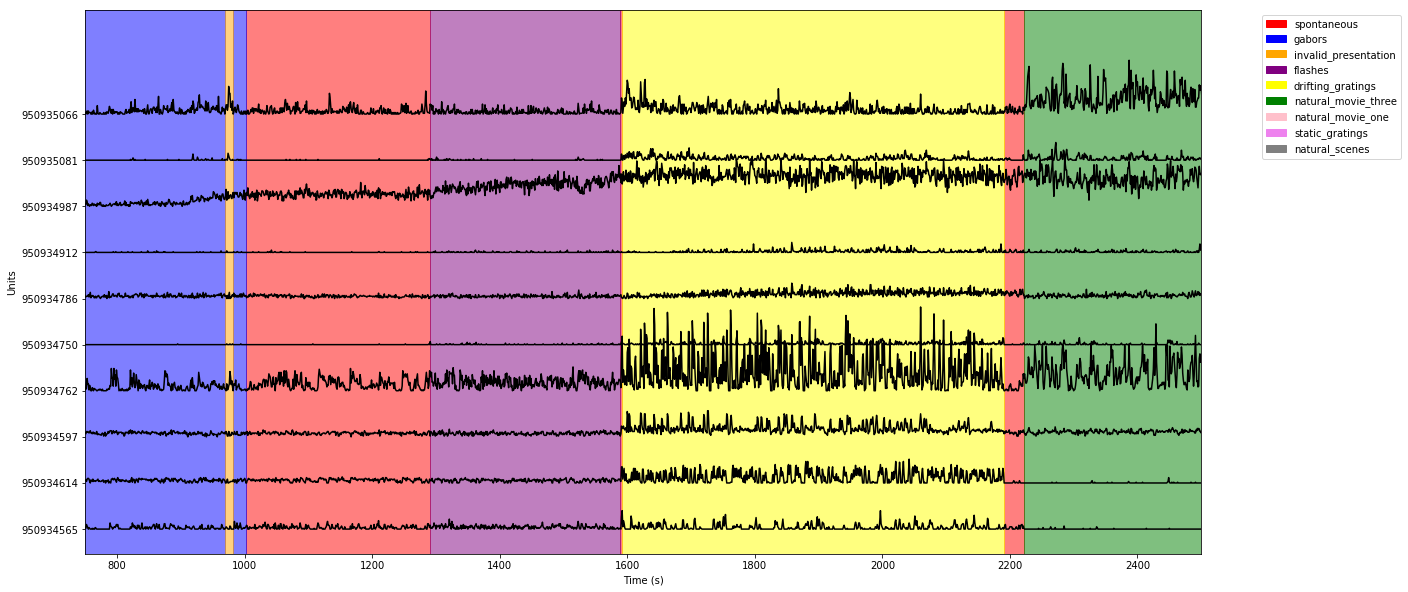

In [34]:
import matplotlib.patches as mpatches

plt.figure(figsize=(20,10))

# Plot first 10 VISp entries spike times in 1 second bins
numunits = 10
numbins = int(np.ceil(VISp_spike_times[0].max()))
visp_binned = np.empty((numunits, numbins))

# Bin each unit's spike times into 1 second bins
for i in range(numunits):
    unit_id = VISp_unit_ids[i]
    spikes = all_spike_times[unit_id]
    for j in range(numbins):
        visp_binned[i,j] = len(spikes[(spikes>j)&(spikes<j+1)])
        
# Plots firing rates, offset each spike train by i
for i in range(numunits):
    plt.plot((i*2)+(visp_binned[i,:]/30.), color='black')

# Plots rectangle blocks that indicate new stimulus presentation 
colors = ['red','blue','orange','purple', 'yellow', 'green', 'pink', 'violet','gray']

for c, stim_name in enumerate(all_stims):
    stim = stim_timeblocks[stim_timeblocks['stimulus_name']==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim['start_time'].iloc[j], 
                    xmax=stim['stop_time'].iloc[j],
                    color = colors[c],
                    alpha = 0.5)
        
# Legend showing stimulus timeblocks
colors_leg = []
for i in range(len(colors)):
    temp_color = mpatches.Patch(color = colors[i], label = (all_stims[i]))
    colors_leg.append(temp_color)  

plt.legend(handles = colors_leg, bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.yticks(ticks = np.arange(0,20,2), labels = VISp_unit_ids[:10])
plt.ylabel('Units')
plt.xlabel('Time (s)')
plt.xlim(750,2500)

plt.show()

Alternatively, you could use the `get_stimulus_table()` method to return a subset of stimulus presentation by `stimulus_name`. The returned dataframe will only contain parameters that relate to the given `stimulus_name`. Below we will investigate how our neuronal units responded to a `natural_scenes` stimulus presentations.

In [27]:
natural_scenes_df = session.get_stimulus_table(['natural_scenes'])
natural_scenes_df.head()

,frame,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,
51353,34,5908.739537,9,natural_scenes,5908.989739,0.250201,4908.0
51354,6,5908.989739,9,natural_scenes,5909.239940,0.250201,4909.0
51355,28,5909.239940,9,natural_scenes,5909.490142,0.250201,4910.0
51356,109,5909.490142,9,natural_scenes,5909.740343,0.250201,4911.0
51357,105,5909.740343,9,natural_scenes,5909.990554,0.250211,4912.0


We can look even further and check how the parameters of a stimulus affected the firing rate. In `natural_scenes` presentations, different frames/images were presented to the mouse. Below we will focus on the times that the first `frame` in `natural_scenes_df`, was presented in the session. 

In [28]:
# Assign indices for presentations of our frame of interest
natural_scenes_ids = natural_scenes_df.index

# Assign 'natural_scenes' image id of interest
my_image = natural_scenes_df.loc[natural_scenes_ids[1], 'frame']

# Return the number of times this image was presented
print('Number of times frame ' + str(my_image)+ ' was presented in the session:')
print(len(natural_scenes_df[natural_scenes_df['frame']==my_image]))

Number of times frame 6.0 was presented in the session:
50


As you can see from the dataframe above, we also have start and end times for a given stimulus presentation available to us. We can do what we did before and use `plt.axvspan()` to plot the times when the images of interest was presented over the firing rates of our session. 

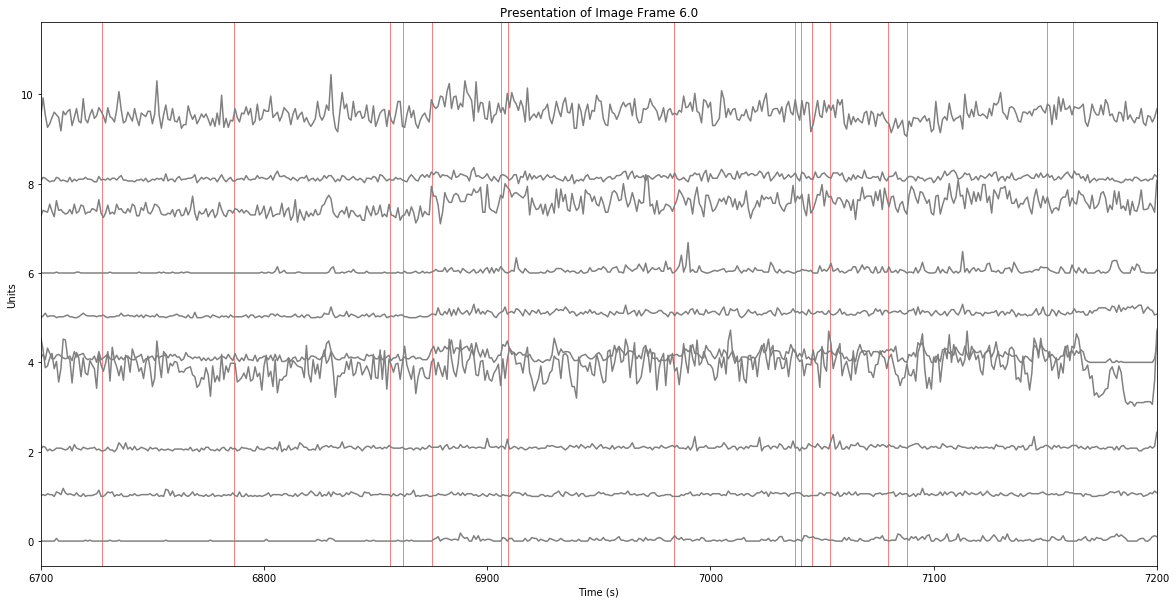

In [36]:
plt.figure(figsize=(20,10))

# Assign a dataframe that only contains presentations of our image of interest
stim_subset = natural_scenes_df[natural_scenes_df['frame']==my_image]

# Offset the firing rates and plot them
for i in range(numunits):
    plt.plot(i+(visp_binned[i,:]/50), color='gray')

# Plot the times are image of interest was presented
for j in range(len(stim_subset)):
    plt.axvspan(xmin=stim_subset['start_time'].iloc[j], xmax=stim_subset['start_time'].iloc[j], color='r', alpha=0.5)

plt.title('Presentation of Image Frame ' + str(my_image))
plt.xlabel('Time (s)')
plt.ylabel('Units')
plt.xlim(6700,7200)
plt.show()

You are not limited to only plotting the times where a certain image was presented, nor are you limited to only plotting `natural_scenes` stimuli. You can create a similar graph with `gabors`, `flashes`, or any other availabe `stimulus_name`. For example, you can plot all the times when a `gabors` stimulus was presented at a certain spatial frequncy, temporal frequency, or orientaion. You can use `get_stimulus_parameter_values` to return a dictionary of all parameters used in a session. 

## Using the Spykes module to plot electrophysiology data

Peristimulus time histograms and raster plots can also be created with classes and methods from a package called `spykes`, which contains useful tools for plotting electrophysiology data. If you do not have `spykes` installed, run the cell below. Otherwise, you can skip to the next cell.

In [ ]:
!pip install spykes

With `spykes`, we can plot the firing activity of single neurons or of neuron populations. The `NeuroVis()` class is used to visualize single neuron activity. It takes in an array of spike times as an argument as well as the `name` of the neuron. We can then use the fucntion `get_raster()` to compute and plot a raster plot across all stimulus presentations. 

Please visit the<a href = 'http://kordinglab.com/spykes/api/plot.html'> spykes plotting section</a> of the spykes documentation for additional help on the classes and functions used below. 

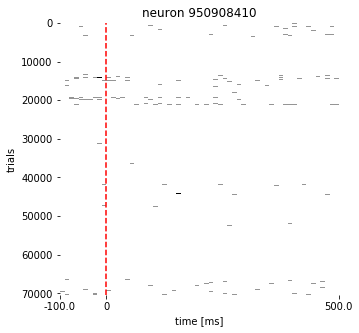

In [38]:
nvs = NeuroVis(VISp_spike_times[0], name = '950908410')

fig = plt.figure(figsize=(5, 5))

nvs.get_raster(event='start_time', df=stim_pres)
plt.show()

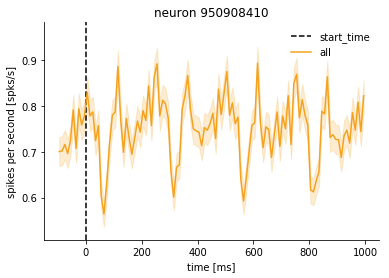

In [39]:
nvs.get_psth(event='start_time', df=stim_pres, binsize = 10, window = [-100, 1000])
plt.show()

## Running Speed

The Allen Institute researchers also collected data on the running speed of their mice. You can access the running speed by calling `running_speed` on our `EcephysSession` object. This will return a dataframe that contains the `start_time`, `end_time`, and `velocity` of our session.

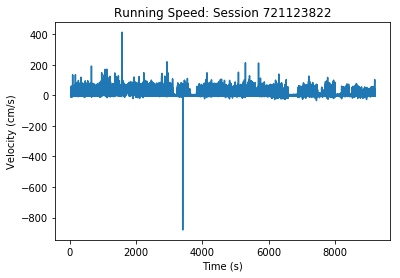

In [51]:
running_speed = session.running_speed

plt.plot(running_speed['end_time'], running_speed['velocity'])
plt.title('Running Speed: Session 721123822')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (cm/s)')
plt.show()

With the running speed, we can ask if there is a correlation between the firing rates of our units and the velocity of our mouse. Similar to how we plotted above, we can plot the running speed of the session over the firing rates and see if increases in running speed align with increases in neural activity. 

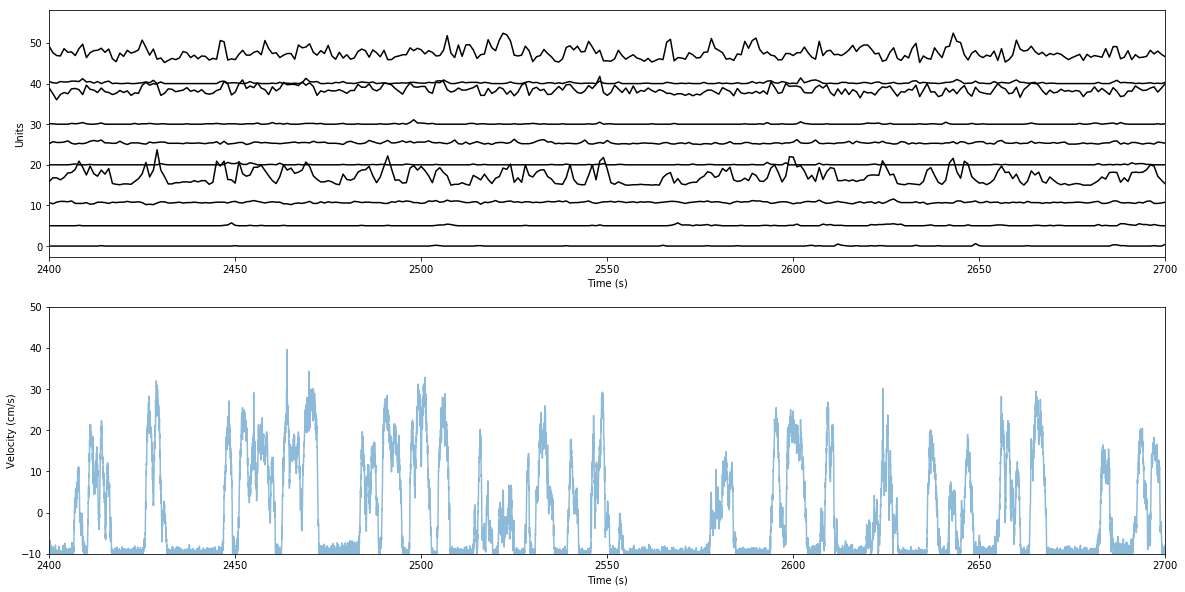

In [46]:
fig, ax = plt.subplots(2, figsize = (20,10) )

# Plot firing rates
for i in range(numunits):
    ax[0].plot((i*5)+(visp_binned[i,:]/10), color='black')

ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Units')
ax[0].set_xlim(2400,2700)

# Plot the running speed underneath     
ax[1].plot(running_speed['end_time'], (running_speed['velocity']*0.5)-10, alpha = 0.5)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Velocity (cm/s)')
ax[1].set_xlim(2400,2700)
ax[1].set_ylim(-10,50)

plt.show()

Even by eye, you can see that the firing rate of the fourth neuron we plotted (and maybe a couple others) seem to be correlated with the mouse's running speed.